# Building A Spotify Recommender

## Part 1: Data Preprocessing

To do:
- check API reference for additional data that can be pulled in for artist/genres
- join data via sql
- clean data

In [130]:
import os
import re
import pandas as pd
import numpy as np
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from secrets import SPOTIFY_HISTORY_DB

## Import Data

First we setup the connection to the SQL DB which contains 3 tables:
- **streaming_history**: each song listened to starting 02-01-2021
- **genres**: each of the artists from streaming_history, tagged with their corresponding genre
- **song_features**: each track from streaming_history, with details at the song level 
    - details include corresponding track values (liveness, tempo, valence etc.)

In [131]:
conn = sqlite3.connect(SPOTIFY_HISTORY_DB)

df_sh = pd.read_sql_query("SELECT * FROM streaming_history", conn)
df_genres = pd.read_sql_query("SELECT * FROM genres", conn)
df_features = pd.read_sql_query("SELECT * FROM song_features", conn)

In [132]:
df_sh.tail(1)

,spotify_id,uri,song_name,artist_name,played_at,duration_ms,date,ETL_DTTM,artist_uri
4984,57pRUe152ADvLINx0or1m8,spotify:track:57pRUe152ADvLINx0or1m8,Famoso,Sfera Ebbasta,2021-10-18 16:24:11.066000,140000,2021-10-18,"2021-10-19, 11:14:17",23TFHmajVfBtlRx5MXqgoz


In [133]:
df_genres.head(1)

,spotify_url,total_followers,genres,artist_id,artist_name,popularity,uri,ETL_DTTM
0,https://open.spotify.com/artist/3SFVIUlipGj3Rp...,48610,"['bass trap', 'traprun']",3SFVIUlipGj3RpWCKe9s73,Lox Chatterbox,58,spotify:artist:3SFVIUlipGj3RpWCKe9s73,"2021-02-14, 09:25:59"


In [134]:
df_features.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,ETL_DTTM
0,0.754,0.763,1,-6.57,1,0.295,0.32,0.0,0.143,0.704,159.963,audio_features,5ZcmLAogrj4HF8Odrz9XA2,spotify:track:5ZcmLAogrj4HF8Odrz9XA2,https://api.spotify.com/v1/tracks/5ZcmLAogrj4H...,https://api.spotify.com/v1/audio-analysis/5Zcm...,265693,3,"2021-02-04, 23:13:23"


The final query merges the data from the 3 tables into one master table, removing any potential duplicate records. If the same song was played over multiple days, there would be many.

In [135]:
merged_query = """
SELECT DISTINCT sh.spotify_id
    ,sh.uri
    ,sh.song_name
    ,sh.artist_name
    ,sh.artist_uri
    ,sh.played_at
    ,sh.date
    ,ETL_DTTM
    ,g.genres
    ,g.popularity
    ,sf.*
FROM streaming_history sh 
LEFT JOIN (SELECT DISTINCT *
    FROM (SELECT DISTINCT artist_id 
                ,artist_name
                ,genres
                ,popularity
                ,row_number() over (partition by artist_id order by artist_id, ETL_DTTM) as dup
            FROM genres)
    WHERE dup = 1) g
ON sh.artist_uri = g.artist_id
LEFT JOIN (SELECT DISTINCT id -- spotify track id
    ,danceability
    ,energy
    ,"key"
    ,loudness
    ,mode
    ,speechiness
    ,acousticness
    ,instrumentalness
    ,liveness
    ,valence
    ,tempo
    ,duration_ms
    ,time_signature
FROM song_features) sf
ON sh.spotify_id = sf.id
order by played_at
"""

df_spotify = pd.read_sql_query(merged_query, conn)

In [136]:
df_spotify.tail()

,spotify_id,uri,song_name,artist_name,artist_uri,played_at,date,ETL_DTTM,genres,popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
4980,1jga15eYrlNMUMqcJ2GLiK,spotify:track:1jga15eYrlNMUMqcJ2GLiK,Macarena (feat. Offset),Sfera Ebbasta,23TFHmajVfBtlRx5MXqgoz,2021-10-18 16:36:26.075000,2021-10-18,"2021-10-19, 11:14:17","['italian hip hop', 'italian pop', 'trap itali...",79.0,...,-5.540,0.0,0.0503,0.141,0.0,0.1820,0.305,124.059,158043.0,4.0
4981,0WXU7I74NEN1DMLIT406Wx,spotify:track:0WXU7I74NEN1DMLIT406Wx,Hollywood (feat. Diplo),Sfera Ebbasta,23TFHmajVfBtlRx5MXqgoz,2021-10-18 16:39:38.068000,2021-10-18,"2021-10-19, 11:14:17","['italian hip hop', 'italian pop', 'trap itali...",79.0,...,-6.336,1.0,0.0366,0.153,0.0,0.0948,0.926,137.973,191869.0,4.0
4982,57pRUe152ADvLINx0or1m8,spotify:track:57pRUe152ADvLINx0or1m8,Famoso,Sfera Ebbasta,23TFHmajVfBtlRx5MXqgoz,2021-10-18 16:43:01.028000,2021-10-18,"2021-10-19, 11:14:17","['italian hip hop', 'italian pop', 'trap itali...",79.0,...,-7.613,0.0,0.0351,0.142,0.0,0.2170,0.503,132.964,140000.0,4.0
4983,57pRUe152ADvLINx0or1m8,spotify:track:57pRUe152ADvLINx0or1m8,Famoso,Sfera Ebbasta,23TFHmajVfBtlRx5MXqgoz,2021-10-18 17:12:39.343000,2021-10-18,"2021-10-19, 11:14:17","['italian hip hop', 'italian pop', 'trap itali...",79.0,...,-7.613,0.0,0.0351,0.142,0.0,0.2170,0.503,132.964,140000.0,4.0
4984,57pRUe152ADvLINx0or1m8,spotify:track:57pRUe152ADvLINx0or1m8,Famoso,Sfera Ebbasta,23TFHmajVfBtlRx5MXqgoz,2021-10-18 21:14:29.522000,2021-10-18,"2021-10-19, 11:14:17","['italian hip hop', 'italian pop', 'trap itali...",79.0,...,-7.613,0.0,0.0351,0.142,0.0,0.2170,0.503,132.964,140000.0,4.0


## EDA & Data Cleaning

A brief data overview extracted directly from Kaggle:

#### Spotify Data Dictionary:
The Spotify API call returns basic track info such as id, song name, artist and genre, but also more detailed values such as:

##### Numerical columns:

- **acousticness**: The relative metric of the track being acoustic, (Ranges from 0 to 1)
- **danceability**: The relative measurement of the track being danceable, (Ranges from 0 to 1)
- **energy**: The energy of the track, (Ranges from 0 to 1)
- **duration_ms**: The length of the track in milliseconds (ms), (Integer typically ranging from 200k to 300k)
- **instrumentalness**: The relative ratio of the track being instrumental, (Ranges from 0 to 1)
- **valence**: The positiveness of the track, (Ranges from 0 to 1)
- **popularity**: The popularity of the song lately, default country = US, (Ranges from 0 to 100)
- **tempo**:The tempo of the track in Beat Per Minute (BPM), (Float typically ranging from 50 to 150)
- **liveness**: The relative duration of the track sounding as a live performance, (Ranges from 0 to 1)
- **loudness**: Relative loudness of the track in decibel (dB), (Float typically ranging from -60 to 0)
- **speechiness**: The relative length of the track containing any kind of human voice, (Ranges from 0 to 1)
- **year**: The release year of track, (Ranges from 1921 to 2020)
- **id**: The primary identifier for the track, generated by Spotify

##### Categorical columns:

- **key**: The primary key of the track encoded as integers in between 0 and 11 (starting on C as 0, C# as 1 and so on…)
- **artists**: The list of artists credited for production of the track
- **release_date**: Date of release mostly in yyyy-mm-dd format, however precision of date may vary
- **name**: The title of the track
- **mode**: The binary value representing whether the track starts with a major (1) chord progression or a minor (0)
- **explicit**: The binary value whether the track contains explicit content or not, (0 = No explicit content, 1 = Explicit content)

In [137]:
print("Total number of songs streamed: ", len(df_spotify))
print("Number of unique songs: ", len(df_spotify.spotify_id.unique()))
print("Number of unique artists: ", len(df_spotify.artist_uri.unique()))

Total number of songs streamed:  4985
Number of unique songs:  1248
Number of unique artists:  442


In [138]:
df_spotify.dtypes

spotify_id           object
uri                  object
song_name            object
artist_name          object
artist_uri           object
played_at            object
date                 object
ETL_DTTM             object
genres               object
popularity          float64
id                   object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
time_signature      float64
dtype: object

In [139]:
df_spotify['genres'].values[4362]

"['belgian dance', 'belgian edm', 'big room', 'dance pop', 'edm', 'electro house', 'pop dance', 'progressive electro house', 'tropical house']"

We see that the genres column appears to be a list at first glance, but is not actually in a list format:

In [140]:
df_spotify['genres'].values[4362][0]

'['

To fix this, a Regular Expression (regex) statement will be used to return a list for each genre. For records without a genre, an empty list will be input.

In [141]:
df_spotify['genres'] = df_spotify['genres'].fillna('[]').apply(lambda x: [re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])

In [142]:
df_spotify['genres'].values[4362][0]

'belgian_dance'

In [143]:
# create list of columns which are numeric
num = df_spotify.select_dtypes(include=np.number)
column_list = num.columns.to_list()

At this point I would like to visualize the distribution of the many data points available. Some knowledge of key attributes may help with model building later on. 

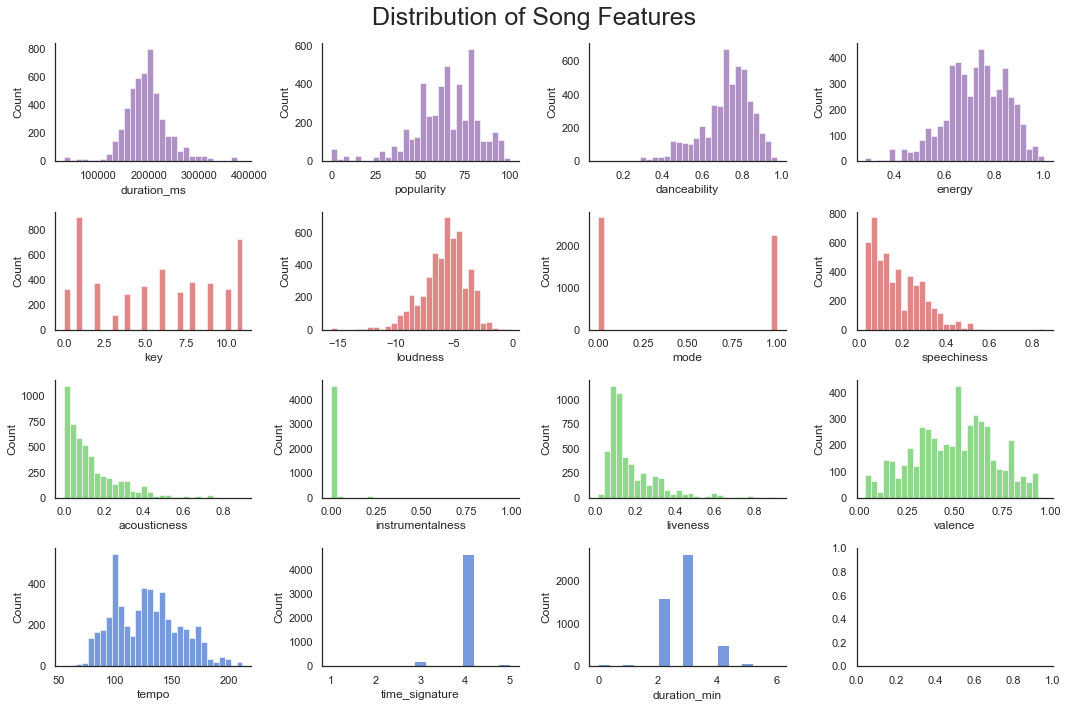

In [144]:
sns.set(style="white", palette="muted", color_codes=True)

fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=False)
sns.despine(right=True)

sns.histplot(df_spotify['duration_ms'], kde=False, bins=30, ax=axes[0, 0], color="m")
sns.histplot(df_spotify['popularity'], kde=False, bins=30, ax=axes[0, 1], color="m")
sns.histplot(df_spotify['danceability'], kde=False, bins=30, ax=axes[0, 2], color="m")
sns.histplot(df_spotify['energy'], kde=False, bins=30, ax=axes[0, 3], color="m")

sns.histplot(df_spotify['key'], kde=False, bins=30, ax=axes[1, 0], color="r")
sns.histplot(df_spotify['loudness'], kde=False, bins=30, ax=axes[1, 1], color="r")
sns.histplot(df_spotify['mode'], kde=False, bins=30, ax=axes[1, 2], color="r")
sns.histplot(df_spotify['speechiness'], kde=False, bins=30, ax=axes[1, 3], color="r")

sns.histplot(df_spotify['acousticness'], kde=False, bins=30, ax=axes[2, 0], color="g")
sns.histplot(df_spotify['instrumentalness'], kde=False, bins=30, ax=axes[2, 1], color="g")
sns.histplot(df_spotify['liveness'], kde=False, bins=30, ax=axes[2, 2], color="g")
sns.histplot(df_spotify['valence'], kde=False, bins=30, ax=axes[2, 3], color="g")

sns.histplot(df_spotify['tempo'], kde=False, bins=30, ax=axes[3, 0])
sns.histplot(df_spotify['time_signature'], kde=False, bins=15, ax=axes[3, 1])
sns.histplot(df_spotify['duration_ms'] // 60000, kde=False, bins=15, ax=axes[3, 2]).set_xlabel('duration_min')
#sns.histplot(df_spotify['valence'], kde=False, bins=30, ax=axes[3, 3])

plt.suptitle('Distribution of Song Features', fontsize=25)
plt.tight_layout()

<AxesSubplot:>

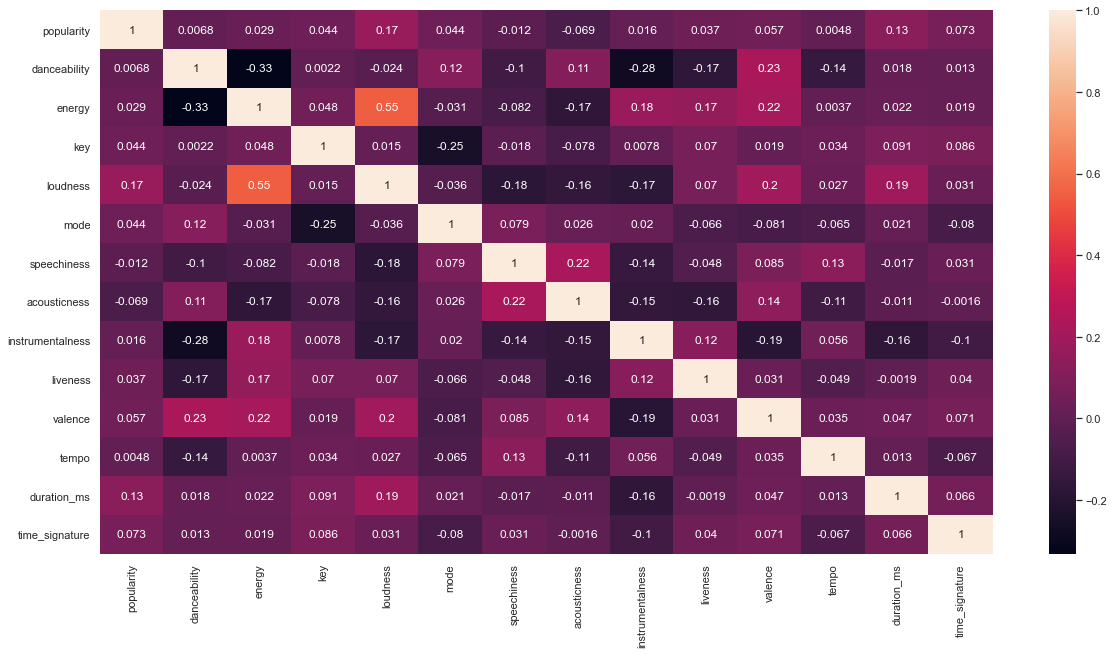

In [160]:
# Correlation between attributes
plt.figure(figsize = (20,10))
sns.heatmap(df_spotify.corr(), annot=True)

Below we can see that the majority of tracks were played less than 10 times (frequency). On this basis, I can consider a playback count of >10 times to be one of my more favourite songs.

Text(0.5, 1.0, 'Distribution of Song Playback Frequency')

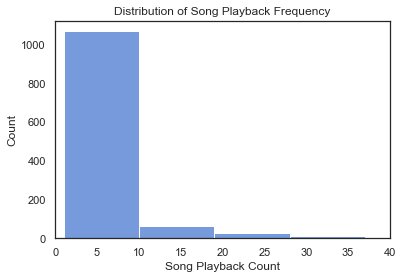

In [146]:
sns.histplot(playback_count['count'], bins=10).set(xlim=(0,40))
plt.xlabel('Song Playback Count')
plt.ylabel('Count')
plt.title('Distribution of Song Playback Frequency')

# ax = playback_count.plot(kind='hist', bins=9)
# ax.set_xlim(0,40)
# ax.set_title("Distribution of Playback Frequency")

In [147]:
df_fav = df_spotify.groupby(['song_name', 'artist_name', 'spotify_id']).size().to_frame('count').sort_values(['count'], ascending=False).reset_index()
df_fav = df_fav[df_fav['count'] >= 10]

In [159]:
pd.read_sql_query("""
SELECT DISTINCT spotify_id, song_name, artist_name, Count(*) AS playback_count 
FROM streaming_history
GROUP BY 1,2,3
HAVING playback_count >= 10
ORDER BY playback_count DESC
""", conn)

,spotify_id,song_name,artist_name,playback_count
0,2oZagYx3ZyigFqguLrbon9,Puertosol Golden Coast,Vegas Jones,92
1,63ZHGDgE804BwJfCZkX1Vy,AMG,Sacky,85
2,4dVpf9jZjcORqGTLUaeYj9,Plain Jane,A$AP Ferg,59
3,3YXOKfDchF2QRNXXJpgmCx,"Shotta 2 (feat. Vale Pain, Baby Gang, Nko)",RM4E,51
4,1zsnUOfuMirWoprylSMuTZ,Gucci Ski Mask (feat. Guè Pequeno),Lazza,47
...,...,...,...,...
117,2Ql6a8RK17IdznRk1oL32u,Porco,Vacca,10
118,32PvWl5JCrlI8XeZxpS6CE,Trappo zarro,Edo Fendy,10
119,4gAxLlI7QGIXzjmtg0RJNd,Muévelo,Wisin,10
120,6gBFPUFcJLzWGx4lenP6h2,goosebumps,Travis Scott,10


In [158]:
pd.read_sql_query("""
select avg(playback_count) as avg_playback_count
from (
SELECT DISTINCT spotify_id, song_name, artist_name, Count(*) AS playback_count 
FROM streaming_history
GROUP BY 1,2,3) S
""", conn)

,avg_playback_count
0,3.984812


Load Spotify features data set of 1.2m tracks

https://www.kaggle.com/rodolfofigueroa/spotify-12m-songs

In [149]:
# import spotify dataset of 1.2m track features

spotify_tracks_df = pd.read_csv("tracks_features.csv")
spotify_tracks_df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [150]:
spotify_tracks_df["favourite"] = np.where(spotify_tracks_df.id.isin(df_fav.spotify_id),1,0)

In [151]:
spotify_tracks_df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,favourite
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02,0
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02,0
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02,0
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02,0
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02,0


<AxesSubplot:>

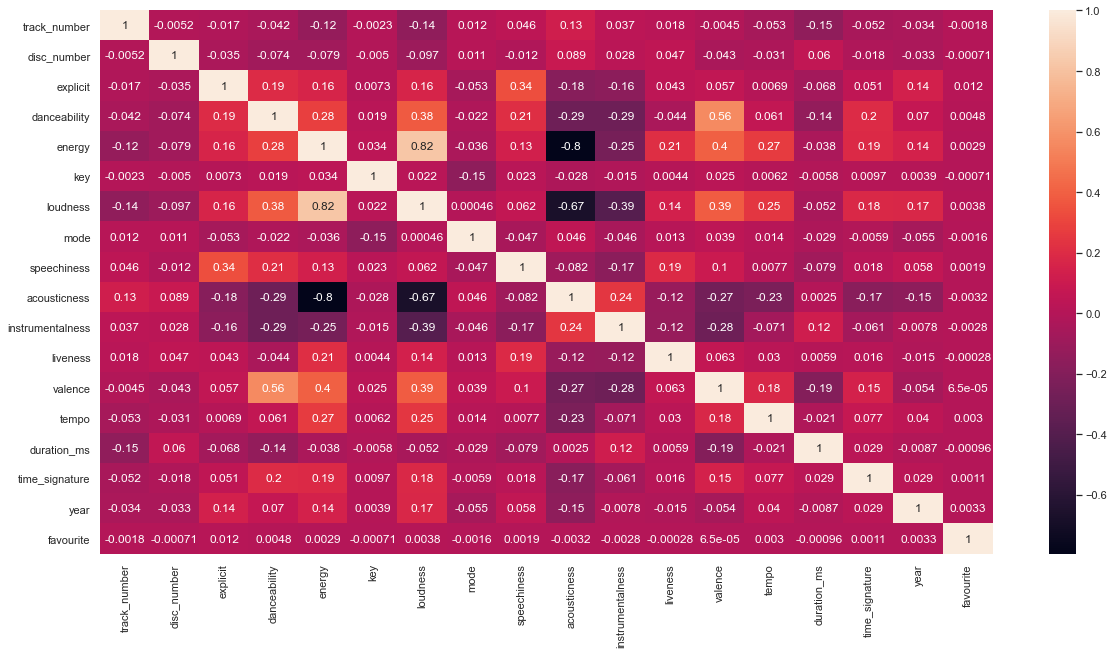

In [152]:
# Correlation between attributes
plt.figure(figsize = (20,10))
sns.heatmap(spotify_tracks_df.corr(), annot=True)

Next steps:
- remove text columns
- standard scaler
- smote oversampling
- start model building

## Part 2: Feature Engineering